## **Alzheimer's Disease Prediction**


### Read the Data

In [1]:
!pip install tensorflow catboost shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("/content/alzheimers_disease_data.csv")
data.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

### Exploratory Data Analysis

In [4]:
print("Dataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   

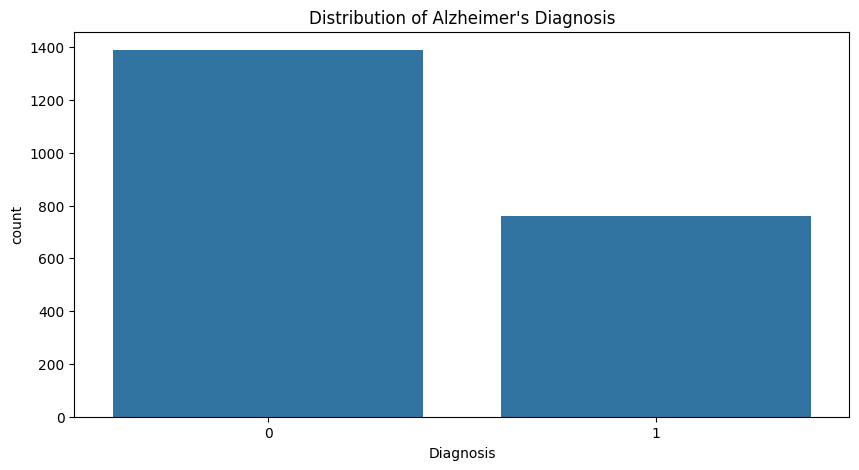

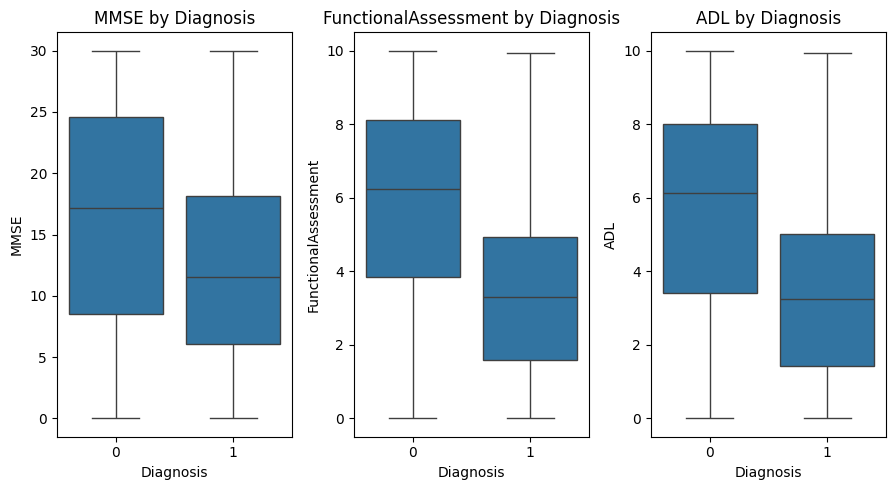

In [5]:
# Plot distribution of Alzheimer's Diagnosis and Cognitive and Functional Assessments Scores
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Diagnosis')
plt.title('Distribution of Alzheimer\'s Diagnosis')
plt.show()

medical_features = ['MMSE', 'FunctionalAssessment', 'ADL']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(medical_features):
    plt.subplot(1, 5, i+1)
    sns.boxplot(data=data, x='Diagnosis', y=feature)
    plt.title(f'{feature} by Diagnosis')
plt.tight_layout()
plt.show()

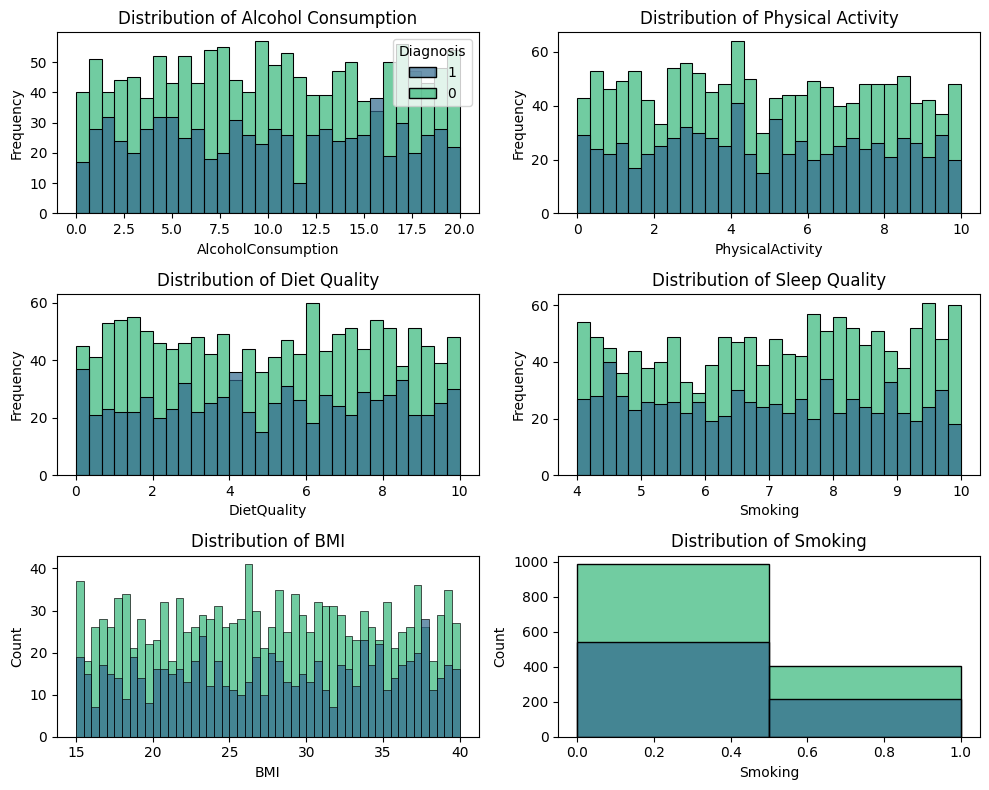

In [6]:
# Plot distribution of Lifestyle Factors based on Diagnosis
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

hue_order = [1, 0]

sns.histplot(ax=axes[0, 0], x='AlcoholConsumption', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', alpha=.7).set(title='Distribution of Alcohol Consumption')
axes[0, 0].set_xlabel('AlcoholConsumption')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[0, 1], x='PhysicalActivity', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Physical Activity')
axes[0, 1].set_xlabel('PhysicalActivity')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 0], x='DietQuality', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Diet Quality')
axes[1, 0].set_xlabel('DietQuality')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 1], x='SleepQuality', data=data, hue='Diagnosis', hue_order=hue_order, bins=30, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Sleep Quality')
axes[1, 1].set_xlabel('SleepQuality')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 0], x='BMI', data=data, hue='Diagnosis', hue_order=hue_order, bins=50, palette='viridis', legend=False, alpha=.7).set(title='Distribution of BMI')
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 1], x='Smoking', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Smoking')
axes[1, 1].set_xlabel('Smoking')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

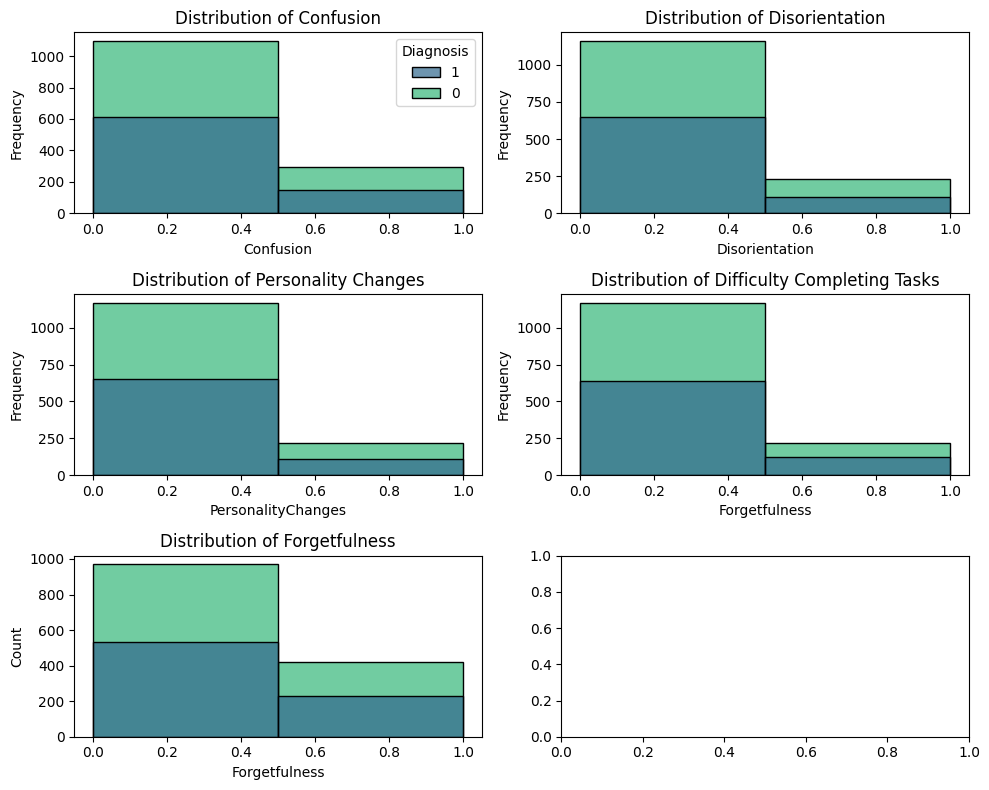

In [7]:
# Plot distribution of symptoms based on Diagnosis
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

hue_order = [1, 0]

sns.histplot(ax=axes[0, 0], x='Confusion', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', alpha=.7).set(title='Distribution of Confusion')
axes[0, 0].set_xlabel('Confusion')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[0, 1], x='Disorientation', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Disorientation')
axes[0, 1].set_xlabel('Disorientation')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 0], x='PersonalityChanges', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Personality Changes')
axes[1, 0].set_xlabel('PersonalityChanges')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(ax=axes[1, 1], x='DifficultyCompletingTasks', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Difficulty Completing Tasks')
axes[1, 1].set_xlabel('DifficultyCompletingTasks')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(ax=axes[2, 0], x='Forgetfulness', data=data, hue='Diagnosis', hue_order=hue_order, bins=2, palette='viridis', legend=False, alpha=.7).set(title='Distribution of Forgetfulness')
axes[1, 1].set_xlabel('Forgetfulness')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

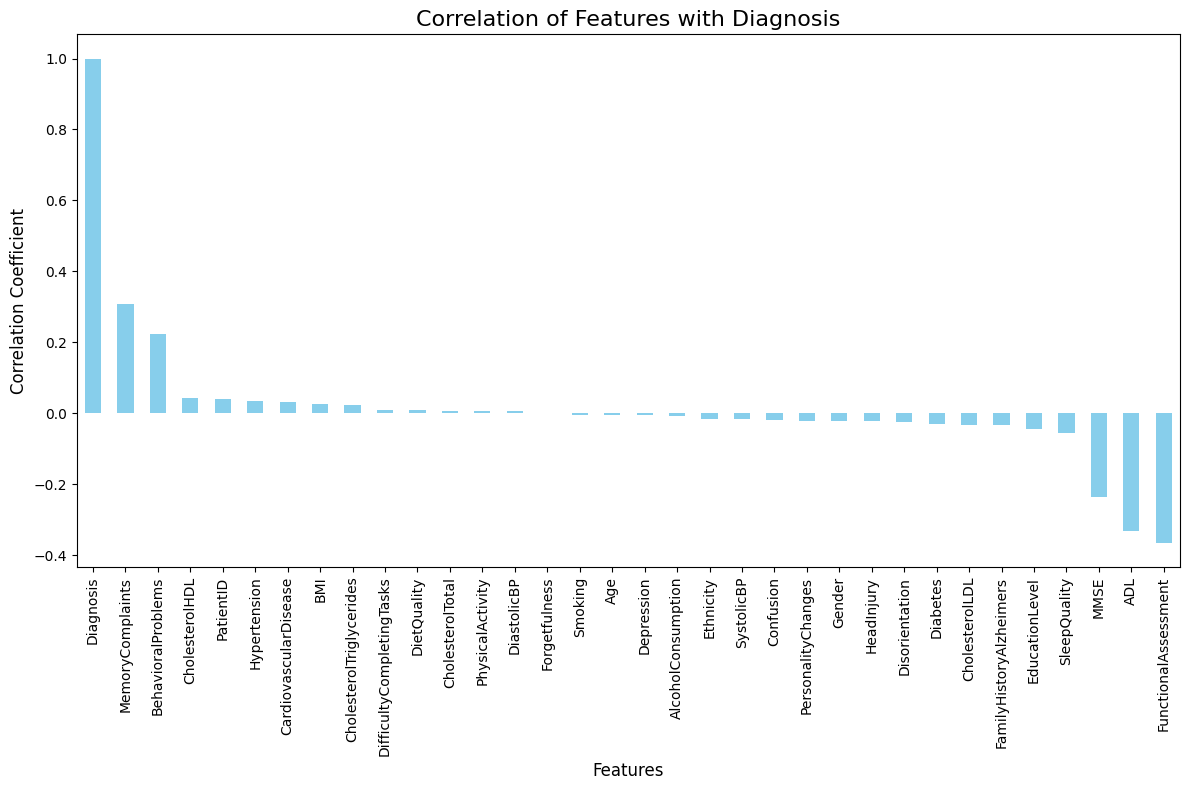

In [8]:
# Find correlation of variables with diagnosis
numeric_data = data.select_dtypes(include=["number"])

corr_diagnosis = numeric_data.corr()['Diagnosis'].sort_values(ascending=False)

# plot the correlation of features with 'Diagnosis'
plt.figure(figsize=(12, 8))
corr_diagnosis.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with Diagnosis", fontsize=16)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

The chart confirms what we already know about how Alzheimer's affects Cognitive and Functional Assessments. Alzheimer's Diagnosis is positively correlated to existence of Memory Complaints and Behavioral Problems, while negatively correlated to Functional Assessment, Activities of Daily Living, and Mini-Mental State Examination scores.

Surprisingly, it is showing that Alzheimer's Diagnosis isn't highly correlated with Age and most Lifestyle Factors (i.e. BMI, Diet Quality, and Physical Activity).

Another thing to note is that the diagnosis also shows lower correlation with the symptoms such as Confusion and Disorientation.

In [9]:
# Check for multicollinearity with VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = numeric_data.drop(columns=['Diagnosis'])

X_with_constant = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_constant.values, i + 1) for i in range(X.shape[1])]

print(vif_data)

                      Feature       VIF
0                   PatientID  1.011579
1                         Age  1.016994
2                      Gender  1.012811
3                   Ethnicity  1.010912
4              EducationLevel  1.017643
5                         BMI  1.017375
6                     Smoking  1.014539
7          AlcoholConsumption  1.009179
8            PhysicalActivity  1.009126
9                 DietQuality  1.015051
10               SleepQuality  1.015419
11    FamilyHistoryAlzheimers  1.011197
12      CardiovascularDisease  1.013989
13                   Diabetes  1.014428
14                 Depression  1.010561
15                 HeadInjury  1.014549
16               Hypertension  1.015086
17                 SystolicBP  1.009060
18                DiastolicBP  1.009631
19           CholesterolTotal  1.011760
20             CholesterolLDL  1.013189
21             CholesterolHDL  1.012858
22   CholesterolTriglycerides  1.014855
23                       MMSE  1.009076


There's no significant multicollinearity between the vairables

# Feature Engineering

In [10]:
#drop columns
data = data.drop(['PatientID', 'DoctorInCharge'], axis=1)

In [11]:
# one-hot encoding
categorical_cols = ['Ethnicity', 'EducationLevel']
data = pd.get_dummies(data, columns=categorical_cols)

In [12]:
# x and y
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# feature selection
selector = SelectFromModel(
    XGBClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

# K-fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_scores = []

# Modeling

In [13]:
# data split
train_idx, val_idx = next(skf.split(X, y))
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# callback setting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

In [14]:
# model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),
          input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# model compiling
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.5615 - loss: 2.6624 - val_accuracy: 0.6512 - val_loss: 2.4242 - learning_rate: 5.0000e-04
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5682 - loss: 2.5745 - val_accuracy: 0.6465 - val_loss: 2.3728 - learning_rate: 5.0000e-04
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6175 - loss: 2.4511 - val_accuracy: 0.6465 - val_loss: 2.3337 - learning_rate: 5.0000e-04
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6487 - loss: 2.3920 - val_accuracy: 0.6488 - val_loss: 2.2961 - learning_rate: 5.0000e-04
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6558 - loss: 2.3434 - val_accuracy: 0.6488 - val_loss: 2.2538 - learning_rate: 5.0000e-04
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6745 - loss: 2.2491 - val_accuracy: 0.6488 - val_loss: 2.2100 - learning_rate: 5.0000e-04
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 

In [15]:
# model
models = {
    'xgb': XGBClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'lgbm': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=4,
        num_leaves=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'catboost': CatBoostClassifier(
        iterations=200,
        learning_rate=0.01,
        depth=4,
        subsample=0.8,
        random_state=42,
        verbose=False
    )
}

# model training
predictions = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    predictions[name] = model.predict_proba(X_val_scaled)[:, 1]

Training xgb...
Training lgbm...
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

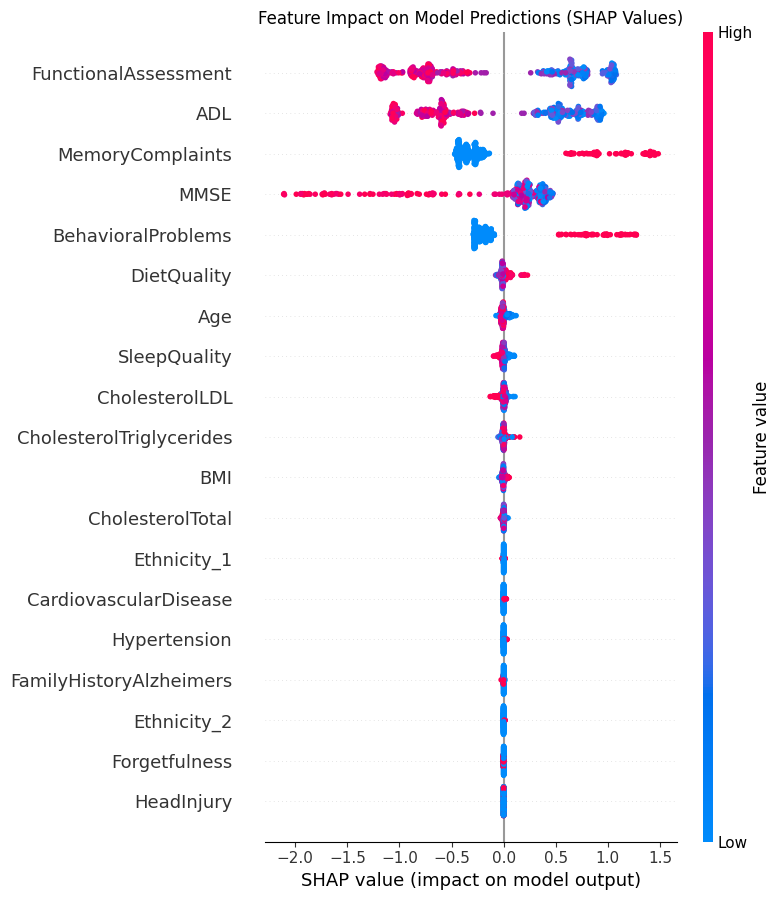

In [16]:
# Model interpretability
# SHAP values calculation
explainer = shap.TreeExplainer(models['xgb'])
shap_values = explainer.shap_values(X_val_scaled)

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_scaled, feature_names=X.columns, show=False)
plt.title('Feature Impact on Model Predictions (SHAP Values)')
plt.tight_layout()
plt.show()

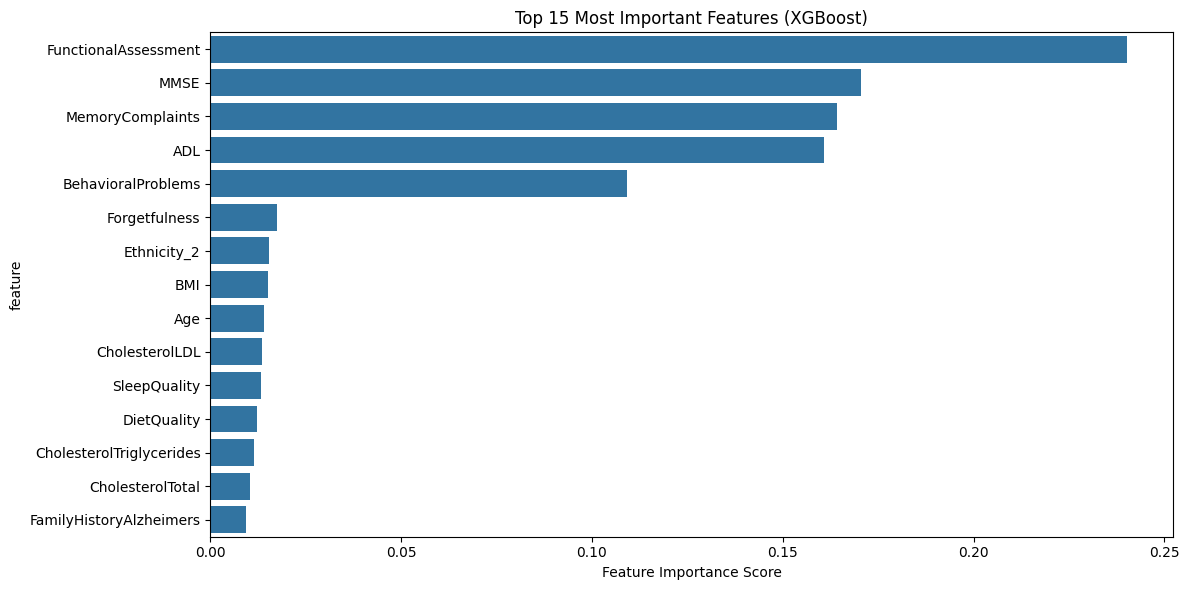

In [17]:
# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models['xgb'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

In [18]:
# Individual prediction explanation function
def explain_prediction(patient_data, model, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'impact': np.abs(shap_values[0])
    }).sort_values('impact', ascending=False).head(5)

    return feature_importance



In [19]:
# Example patient prediction explanation
sample_patient = X_val_scaled[0:1]
explanation = explain_prediction(sample_patient, models['xgb'], X.columns)
print("\nIndividual Patient Prediction Explanation:")
print("Top 5 Contributing Features:")
print(explanation)


Individual Patient Prediction Explanation:
Top 5 Contributing Features:
                 feature    impact
12  FunctionalAssessment  1.166936
15                   ADL  0.479519
13      MemoryComplaints  0.456676
14    BehavioralProblems  0.277158
11                  MMSE  0.150913


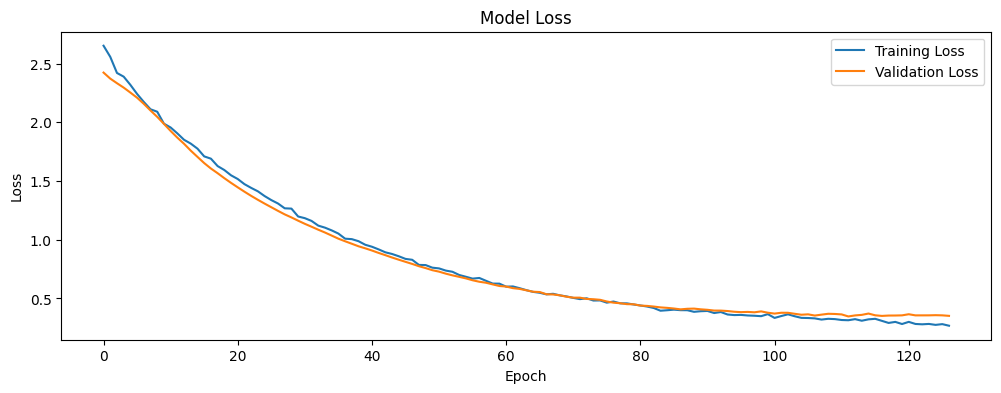

In [20]:
# learning curve
plt.figure(figsize=(12, 4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



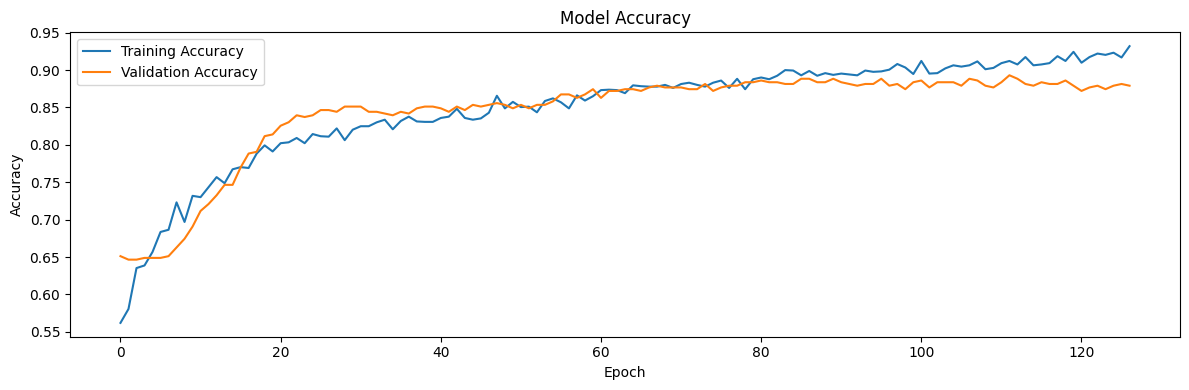

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# deep learning
predictions['deep'] = model.predict(X_val_scaled).ravel()

# ensemble
weights = {'deep': 0.3, 'xgb': 0.3, 'lgbm': 0.2, 'catboost': 0.2}
ensemble_pred = sum(pred * weights[name] for name, pred in predictions.items())
val_pred_binary = (ensemble_pred > 0.5).astype(int)

def calculate_metrics(y_true, y_pred, y_pred_proba):

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred_proba)
    }

print("\n=== Model Performance ===")
for name, pred_proba in predictions.items():
    pred_binary = (pred_proba > 0.5).astype(int)
    metrics = calculate_metrics(y_val, pred_binary, pred_proba)
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# ensemble performance
ensemble_metrics = calculate_metrics(y_val, val_pred_binary, ensemble_pred)
print("\nEnsemble:")
for metric_name, value in ensemble_metrics.items():
    print(f"{metric_name}: {value:.4f}")


=== Model Performance ===

xgb:
Accuracy: 0.9581
Precision: 0.9467
Recall: 0.9342
F1: 0.9404
AUC: 0.9576

lgbm:
Accuracy: 0.9605
Precision: 0.9470
Recall: 0.9408
F1: 0.9439
AUC: 0.9542

catboost:
Accuracy: 0.9558
Precision: 0.9463
Recall: 0.9276
F1: 0.9369
AUC: 0.9598

deep:
Accuracy: 0.9558
Precision: 0.9463
Recall: 0.9276
F1: 0.9369
AUC: 0.9494

Ensemble:
Accuracy: 0.9558
Precision: 0.9463
Recall: 0.9276
F1: 0.9369
AUC: 0.9582


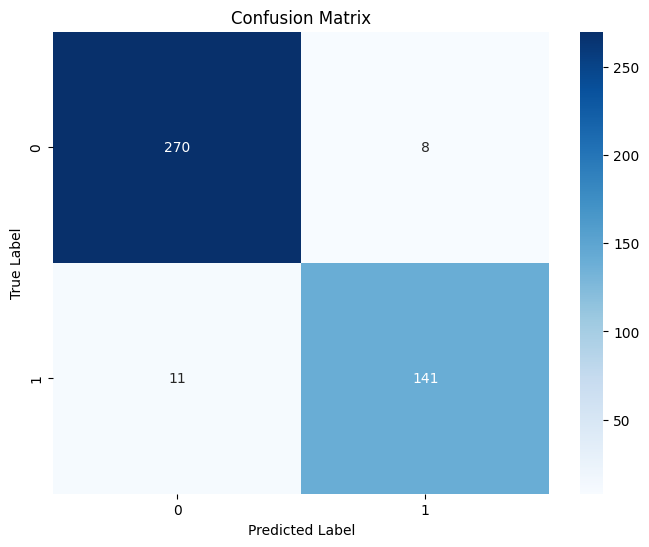

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()